# Audio model initial evaluation
Se evalúa un modelo TensorFlow de sonido entrenado.
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from audio_model_evaluation import *

## Parámetros

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/audio"
label_index_dir = f"{saved_models_dir}/label index mappings"
model_name = f"MicroAudioDataModel"
# model_name = f"ExtAudioDataModel"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"
test_dir = f"{project_dir}/samples/microcontroller/audio/test"
# test_dir = f"{project_dir}/samples/external/audio/test"
# test_dir = f"{project_dir}/samples/microcontroller/audio/all"

## Carga del modelo
Cargamos un modelo y mostramos un resumen de su estructura.

In [3]:
model = load_model(model_dir)
model.summary()

class_names = load(f"{label_index_dir}/{model_name}.joblib")
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

Model: "MicroAudioDataModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 12, 8)         648       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 4)         

## Carga de datos de test
Cargamos los datos de test sobre los que se realizará inferencias.

In [4]:
test_dataset = get_test_dataset(test_dir)

test_audios = []
test_labels = []
for audio, label in test_dataset:
    test_audios.append(audio.numpy())
    test_labels.append(label.numpy())
test_audios = np.array(test_audios)
test_labels = np.array(test_labels)

Se usarán 91 muestras.


## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

In [5]:
predictions = np.argmax(model.predict(test_audios), axis=1)

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

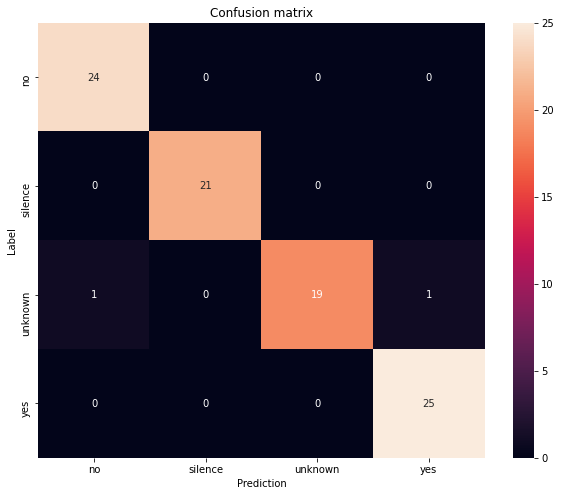

              precision    recall  f1-score   support

          no       0.96      1.00      0.98        24
     silence       1.00      1.00      1.00        21
     unknown       1.00      0.90      0.95        21
         yes       0.96      1.00      0.98        25

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91



In [6]:
confusion_mtx = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(test_labels, predictions, target_names=class_names))